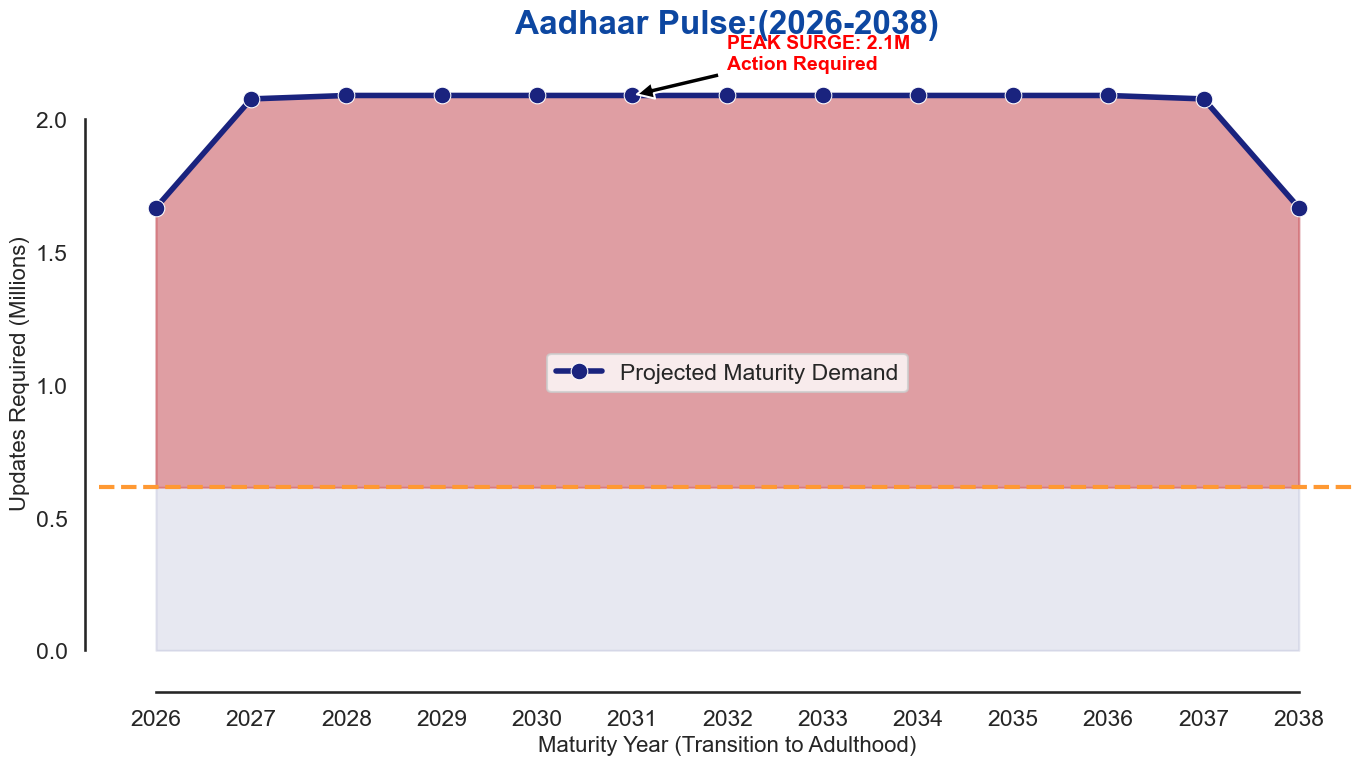

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

df = pd.read_csv("E:\\DATA ANALYTICS\\UIDAI-Data-Hackathon-2026-main\\Biometric\\biometrics_processed.csv")

# Aggregate the 5-17 cohort size
total_5_17 = df['bio_age_5_17'].sum()
current_year = 2025
ages = np.arange(5, 18)
cohort_size = total_5_17 / 13  

forecast_years = np.arange(2026, 2039)
demand = pd.Series(0.0, index=forecast_years)

# 2. GAUSSIAN SMOOTHING 
for age in ages:
    maturity_year = current_year + (18 - age)
    for yr in forecast_years:
        # Probability Density Function to distribute load
        # FIX: The subtraction sign was missing here
        prob = norm.cdf(yr + 0.5, loc=maturity_year, scale=0.6) - \
               norm.cdf(yr - 0.5, loc=maturity_year, scale=0.6)
        demand[yr] += cohort_size * prob

# 3. SCALING TO MILLIONS (Fixed: Ensure Y-axis matches labels)
# Calculate daily average for 18+ and scale for capacity, then convert to Millions
unique_dates_count = len(df['date'].unique())
system_cap = (df['bio_age_17_'].sum() / unique_dates_count * 1.1) / 1e6
demand_m = demand / 1e6

# 4. SEABORN VISUALIZATION
sns.set_theme(style="white", context="talk")
fig, ax = plt.subplots(figsize=(14, 8))

# Demand Curve
sns.lineplot(x=demand_m.index, y=demand_m.values, color="#1A237E", 
             linewidth=4, marker='o', markersize=12, label='Projected Maturity Demand')

plt.fill_between(demand_m.index, demand_m.values, color="#1A237E", alpha=0.1)

# Infrastructure Capacity Line
plt.axhline(y=system_cap, color="#FF9933", linestyle='--', linewidth=3, 
            label='Current Infrastructure Capacity')

# Systemic Stress Zone (Red highlight where demand > capacity)
plt.fill_between(demand_m.index, demand_m.values, system_cap, 
                 where=(demand_m.values > system_cap), 
                 color="#D32F2F", alpha=0.4, label="Systemic Stress Zone", interpolate=True)

# Formatting
plt.title("Aadhaar Pulse:(2026-2038)", 
          fontsize=24, fontweight='bold', pad=25, color='#0D47A1')
plt.ylabel("Updates Required (Millions)", fontsize=16)
plt.xlabel("Maturity Year (Transition to Adulthood)", fontsize=16)
plt.xticks(demand_m.index)

peak_yr = demand_m.idxmax()
plt.annotate(f'PEAK SURGE: {demand_m.max():.1f}M\nAction Required', 
             xy=(peak_yr, demand_m.max()), xytext=(peak_yr+1, demand_m.max()+0.1),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=14, fontweight='bold', color='red')

sns.despine(offset=10, trim=True)
plt.tight_layout()
plt.savefig('corrected_aadhaar_maturity_surge.png', dpi=300)

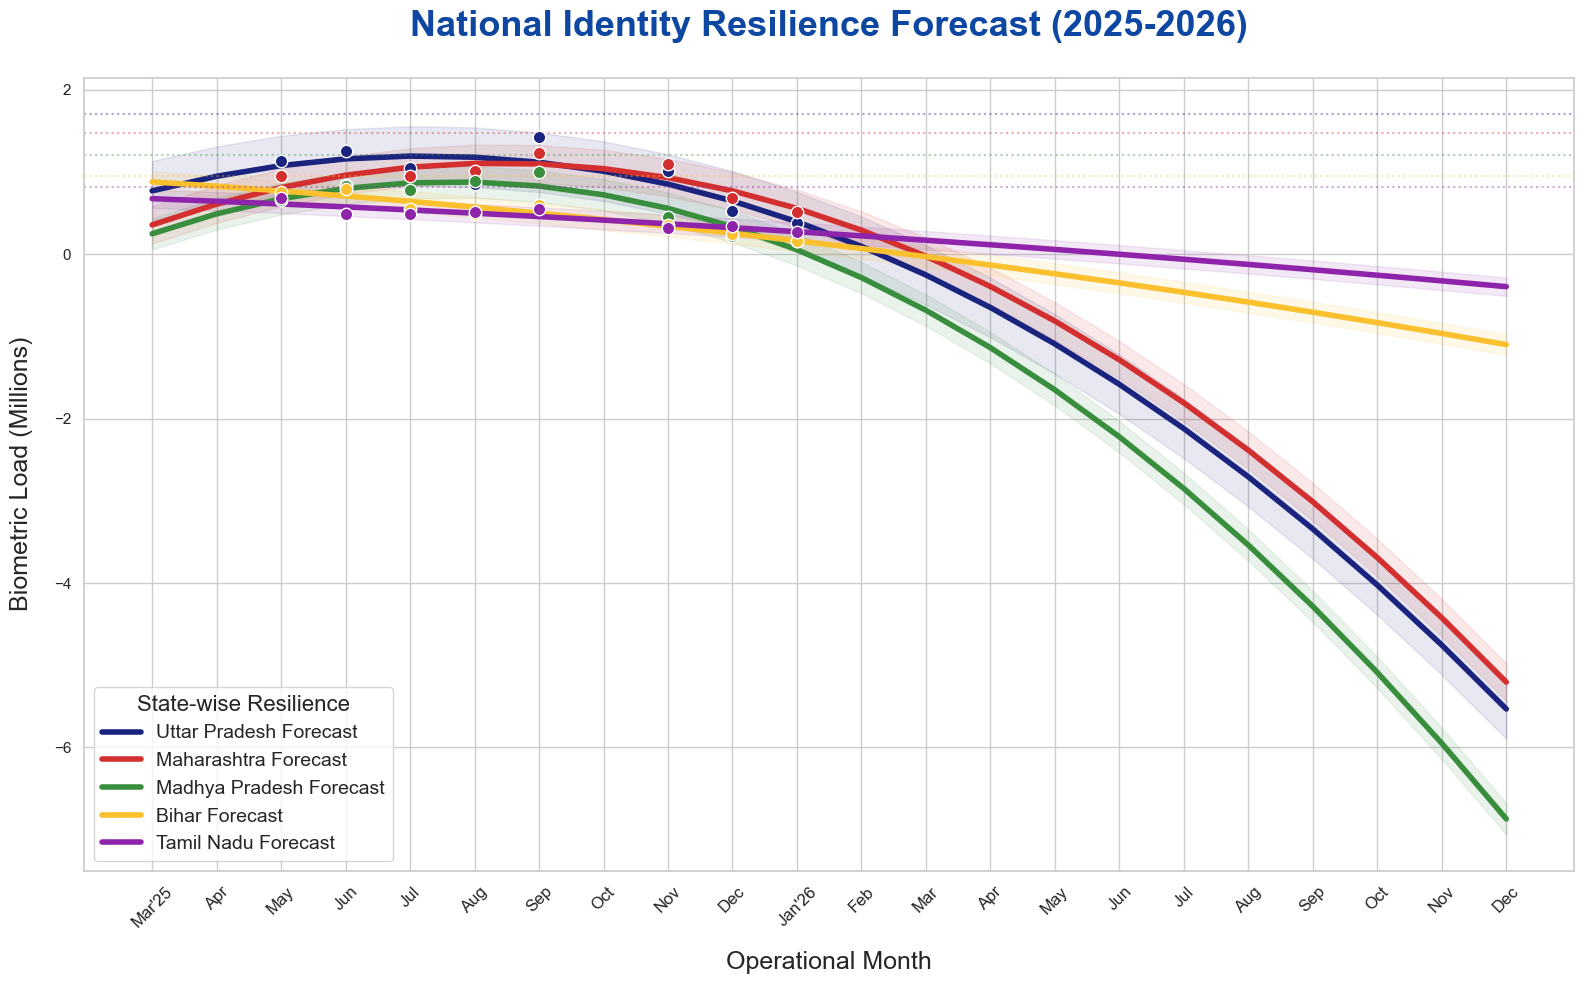

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# --- STEP 1: DATA ENGINEERING ---
# Load the biometric dataset
df = pd.read_csv("E:\\DATA ANALYTICS\\UIDAI-Data-Hackathon-2026-main\\Biometric\\biometrics_processed.csv")
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')
df['total_bio'] = df['bio_age_5_17'] + df['bio_age_17_']


df['month_idx'] = (df['date'].dt.year - 2025) * 12 + df['date'].dt.month

# Grouping data by State and Month to find trends
state_trends = df.groupby(['state', 'month_idx'])['total_bio'].sum().reset_index()

# Select the Top 5 most active states for a high-impact visual
top_5_states = state_trends.groupby('state')['total_bio'].sum().nlargest(5).index.tolist()

future_months = np.arange(1, 23).reshape(-1, 1) 
month_labels = ["Mar'25", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec", 
                "Jan'26", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

plt.figure(figsize=(16, 10))
sns.set_theme(style="whitegrid")
palette = ["#1A237E", "#D32F2F", "#388E3C", "#FBC02D", "#8E24AA"] # Professional UIDAI Palette

for i, state in enumerate(top_5_states):
    # Prepare historical data for the specific state
    state_df = state_trends[state_trends['state'] == state].sort_values('month_idx')
    X = state_df[['month_idx']].values
    y = state_df['total_bio'].values
    
    # POLYNOMIAL MODEL: Captures non-linear growth (surges)
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(X)
    model = LinearRegression().fit(X_poly, y)
    
    # Generate Forecast and Confidence Intervals
    y_pred = model.predict(poly.transform(future_months))
    
    # STOCHASTIC ERROR MODELING
    # Calculate Standard Error of the Residuals to find the 95% Confidence Interval
    y_fitted = model.predict(X_poly)
    std_error = np.std(y - y_fitted)
    lower_bound = y_pred - (1.96 * std_error)
    upper_bound = y_pred + (1.96 * std_error)
    plt.plot(future_months, y_pred/1e6, label=f'{state} Forecast', color=palette[i], linewidth=4)
    plt.fill_between(future_months.flatten(), lower_bound/1e6, upper_bound/1e6, 
                     color=palette[i], alpha=0.1)
    plt.scatter(X, y/1e6, color=palette[i], s=80, edgecolors='white', zorder=5)
    state_capacity = (y.max() * 1.20) / 1e6
    plt.axhline(y=state_capacity, color=palette[i], linestyle=':', alpha=0.4)

plt.title('National Identity Resilience Forecast (2025-2026)', fontsize=26, fontweight='bold', pad=30, color='#0D47A1')
plt.xlabel('Operational Month', fontsize=18, labelpad=15)
plt.ylabel('Biometric Load (Millions)', fontsize=18, labelpad=15)
plt.xticks(np.arange(1, 23), month_labels, rotation=45, fontsize=12)
plt.legend(title="State-wise Resilience", fontsize=14, title_fontsize=16, frameon=True)
plt.tight_layout()
plt.savefig('advanced_identity_resilience_forecast.png', dpi=300)

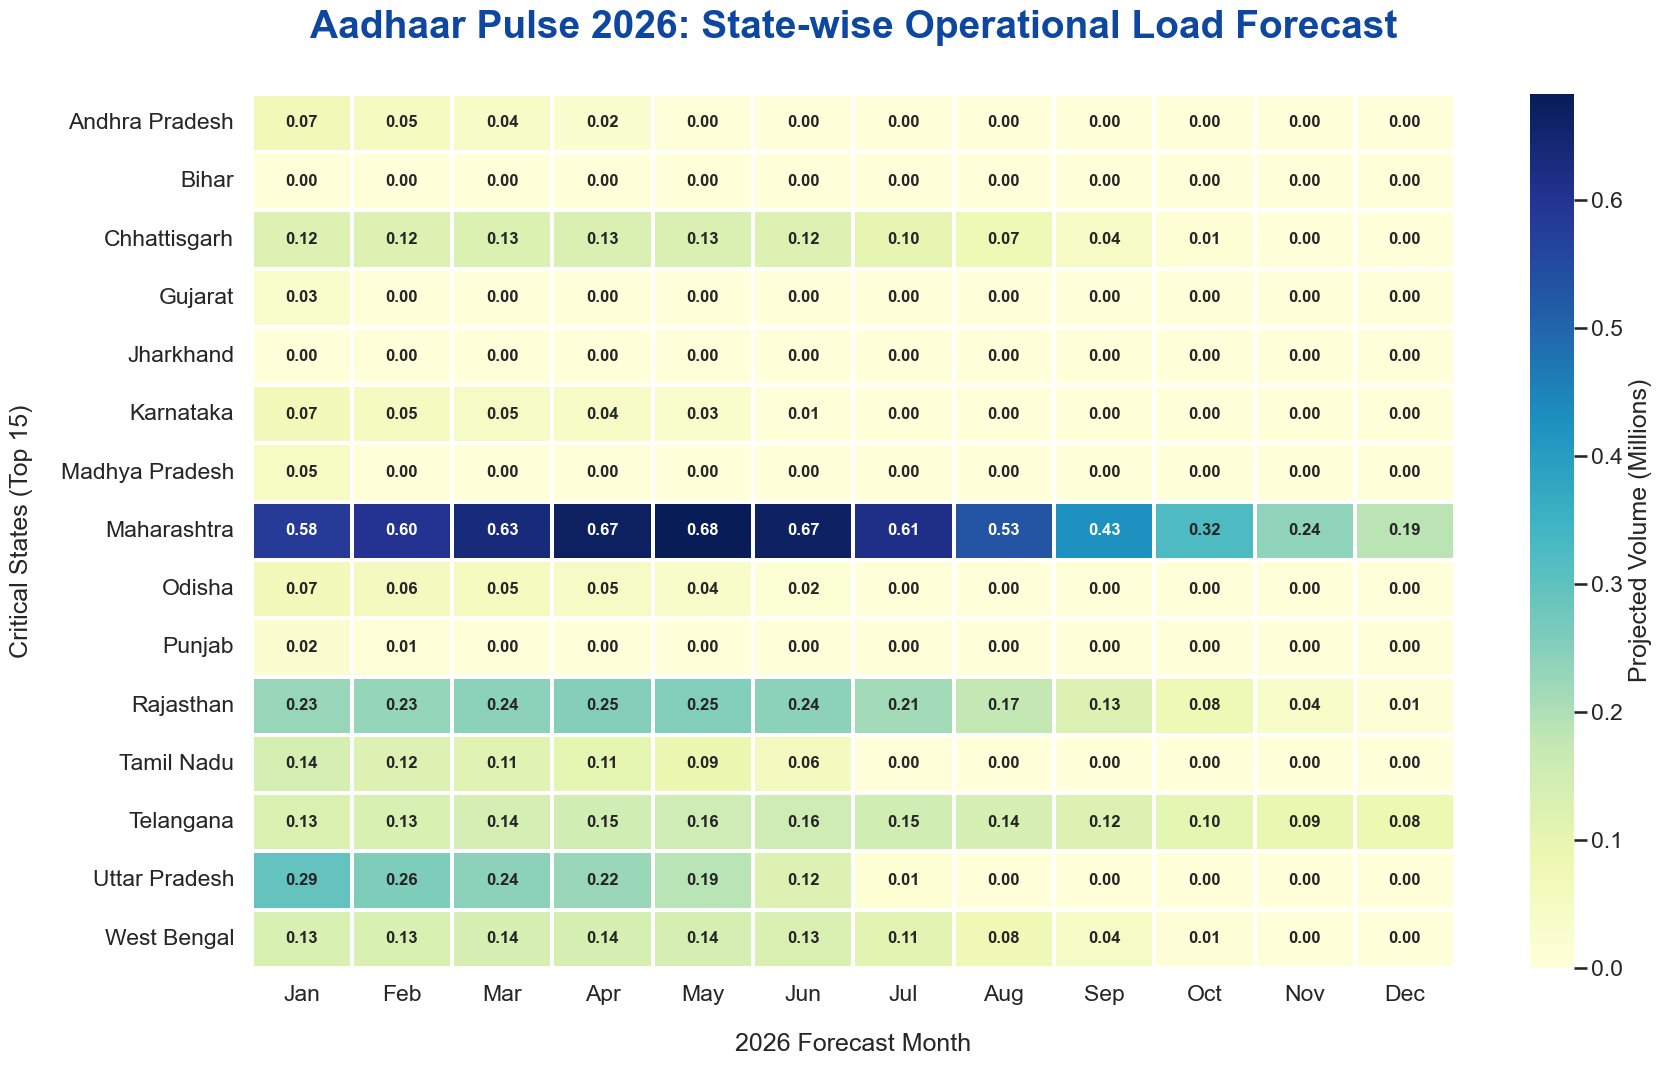

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

df = pd.read_csv("E:\\DATA ANALYTICS\\UIDAI-Data-Hackathon-2026-main\\Biometric\\biometrics_processed.csv")
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')
df['total_bio'] = df['bio_age_5_17'] + df['bio_age_17_']

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['time_index'] = (df['year'] - 2025) * 12 + df['month']
top_states = df.groupby('state')['total_bio'].sum().nlargest(15).index.tolist()
forecast_data = []
future_months_indices = np.arange(13, 25) # Jan 2026 to Dec 2026
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for state in top_states:
    state_data = df[df['state'] == state].groupby('time_index')['total_bio'].sum().reset_index()
    
    if len(state_data) < 2: continue
    
    # Train Linear Regression for Trend
    X = state_data[['time_index']].values
    y = state_data['total_bio'].values
    model = LinearRegression().fit(X, y)
    
    # Predict 2026 base trend
    preds = model.predict(future_months_indices.reshape(-1, 1))
    
    # Apply Seasonal Coefficient (15% variance for school/festive surges)
    seasonality = np.sin(2 * np.pi * (future_months_indices - 3) / 12) * (y.mean() * 0.15)
    final_preds = (preds + seasonality) / 1e6 # Convert to Millions
    
    for i, val in enumerate(final_preds):
        forecast_data.append({'State': state, 'Month': month_labels[i], 'Volume': max(0, val)})

forecast_df = pd.DataFrame(forecast_data)
pivot_df = forecast_df.pivot(index="State", columns="Month", values="Volume")[month_labels]

# 3. HIGH-AESTHETIC VISUALIZATION
plt.figure(figsize=(18, 11))
sns.set_theme(style="white", context="talk")

# Plotting the Heatmap with sophisticated styling
ax = sns.heatmap(pivot_df, annot=True, fmt=".2f", cmap="YlGnBu", 
                 linewidths=1.5, linecolor='white',
                 cbar_kws={'label': 'Projected Volume (Millions)'},
                 annot_kws={"size": 12, "weight": "bold"})
plt.title('Aadhaar Pulse 2026: State-wise Operational Load Forecast', 
          fontsize=28, fontweight='bold', pad=40, color='#0D47A1')
plt.xlabel('2026 Forecast Month', fontsize=18, labelpad=20)
plt.ylabel('Critical States (Top 15)', fontsize=18, labelpad=20)
plt.tight_layout()
plt.savefig('aadhaar_2026_operational_pulse.png', dpi=300)